# PACKAGES AND LIBRARIES

In [1]:
#GENERAL
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
import random
#PATH PROCESS
import os
import os.path
from pathlib import Path
import glob
#IMAGE PROCESS
from PIL import Image
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing import image
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
from scipy.ndimage.filters import convolve
from skimage import data, io, filters
import skimage
from skimage.morphology import convex_hull_image, erosion
#SCALER & TRANSFORMATION
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras import regularizers
from sklearn.preprocessing import LabelEncoder
#ACCURACY CONTROL
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
#OPTIMIZER
from keras.optimizers import RMSprop,Adam,Optimizer,Optimizer, SGD
#MODEL LAYERS
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,MaxPooling2D,BatchNormalization,\
                        Permute, TimeDistributed, Bidirectional,GRU, SimpleRNN, LSTM, GlobalAveragePooling2D, SeparableConv2D,\
ZeroPadding2D, Convolution2D, ZeroPadding2D, Conv2DTranspose,ReLU, UpSampling2D, Concatenate, Conv2DTranspose
from keras import models
from keras import layers
import tensorflow as tf
from keras.applications import VGG16,VGG19,inception_v3
from keras import backend as K
from keras.utils import plot_model
from keras.models import load_model
from keras import backend
#SKLEARN CLASSIFIER
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
#IGNORING WARNINGS
from warnings import filterwarnings
filterwarnings("ignore",category=DeprecationWarning)
filterwarnings("ignore", category=FutureWarning) 
filterwarnings("ignore", category=UserWarning)

# PATH / LABEL / DATA TRANSFORMATION PROCESS

In [2]:
MAIN_IMAGE_PATH = Path("../input/semantic-segmentation-of-underwater-imagery-suim/train_val/images")
MAIN_MASK_PATH = Path("../input/semantic-segmentation-of-underwater-imagery-suim/train_val/masks")

OBJECT_PATH = list(MAIN_IMAGE_PATH.glob(r"*.jpg"))
MASK_PATH = list(MAIN_MASK_PATH.glob(r"*.bmp"))

OBJECT_PATH = sorted(OBJECT_PATH)
MASK_PATH = sorted(MASK_PATH)

OBJECT_SERIES = pd.Series(OBJECT_PATH,name="OBJECTS").astype(str)
MASK_SERIES = pd.Series(MASK_PATH,name="MASK").astype(str)

MAIN_DATA = pd.concat([OBJECT_SERIES,MASK_SERIES],axis=1)

MASK_MAIN_TRANSFORMATION = []
OBJECT_MAIN_TRANSFORMATION = []
ADD_MAIN_TRANSFORMATION = []

for x_image,x_mask in zip(MAIN_DATA.OBJECTS,MAIN_DATA.MASK):
    
    IMAGE_X = cv2.cvtColor(cv2.imread(x_image),cv2.COLOR_BGR2RGB)
    MASK_X = cv2.cvtColor(cv2.imread(x_mask),cv2.COLOR_BGR2RGB)
    
    RESIZED_X_IMAGE = cv2.resize(IMAGE_X,(300,300))
    RESIZED_X_MASK = cv2.resize(MASK_X,(300,300))
    
    ADD_X = cv2.addWeighted(RESIZED_X_IMAGE,0.6,RESIZED_X_MASK,0.6,0.5)
    
    RESIZED_X_ADD = cv2.resize(ADD_X,(300,300))
    
    MASK_MAIN_TRANSFORMATION.append(RESIZED_X_MASK)
    OBJECT_MAIN_TRANSFORMATION.append(RESIZED_X_IMAGE)
    ADD_MAIN_TRANSFORMATION.append(RESIZED_X_ADD)
    
print("WHEN IT IS ARRAY IMAGE SHAPE: ",np.shape(np.array(OBJECT_MAIN_TRANSFORMATION)))
print("WHEN IT IS ARRAY MASK SHAPE: ",np.shape(np.array(MASK_MAIN_TRANSFORMATION)))
print("WHEN IT IS ARRAY ADD SHAPE: ",np.shape(np.array(ADD_MAIN_TRANSFORMATION)))

Transformation_Image = np.array(OBJECT_MAIN_TRANSFORMATION,dtype="float32")
Transformation_Mask = np.array(MASK_MAIN_TRANSFORMATION,dtype="float32")
Transformation_Add = np.array(ADD_MAIN_TRANSFORMATION,dtype="float32")

Transformation_Image = Transformation_Image / 255.
Transformation_Mask = Transformation_Mask / 255.
Transformation_Add = Transformation_Add / 255.

print("TRAIN: ",Transformation_Image.shape)
print("TRANSFORMATION MASK: ",Transformation_Mask.shape)
print("TRANSFORMATION ADD: ",Transformation_Add.shape)

WHEN IT IS ARRAY IMAGE SHAPE:  (1525, 300, 300, 3)
WHEN IT IS ARRAY MASK SHAPE:  (1525, 300, 300, 3)
WHEN IT IS ARRAY ADD SHAPE:  (1525, 300, 300, 3)
TRAIN:  (1525, 300, 300, 3)
TRANSFORMATION MASK:  (1525, 300, 300, 3)
TRANSFORMATION ADD:  (1525, 300, 300, 3)


# AUTO-ENCODER PROCESS / AE

In [3]:
compile_loss = "binary_crossentropy"
compile_optimizer = Adam(lr=0.000001)
output_class = 1

Checkpoint_Model = tf.keras.callbacks.ModelCheckpoint(monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      filepath="./modelcheck")

In [4]:
Encoder_B = Sequential()
Encoder_B.add(Conv2D(32,(2,2),kernel_initializer = 'he_normal',padding = "same",use_bias = True))
Encoder_B.add(BatchNormalization())
Encoder_B.add(ReLU())
#
Encoder_B.add(Conv2D(64,(2,2),kernel_initializer = 'he_normal',padding = "same",use_bias = True))
Encoder_B.add(BatchNormalization())
Encoder_B.add(ReLU())
#
Encoder_B.add(Conv2D(128,(2,2),kernel_initializer = 'he_normal',padding = "same",use_bias = True))
Encoder_B.add(BatchNormalization())
Encoder_B.add(ReLU())


Decoder_B = Sequential()
#
Decoder_B.add(Conv2DTranspose(64,(2,2),padding = "same",use_bias = True))
Decoder_B.add(BatchNormalization())
Decoder_B.add(ReLU())
#
Decoder_B.add(Conv2DTranspose(32,(2,2),padding = "same",use_bias = True))
Decoder_B.add(BatchNormalization())
Decoder_B.add(ReLU())
#
Decoder_B.add(Conv2DTranspose(output_class,(2,2),padding = "same",use_bias = True))
Decoder_B.add(BatchNormalization())
Decoder_B.add(ReLU())

In [5]:
Auto_Encoder = Sequential([Encoder_B,Decoder_B])
Auto_Encoder.compile(loss=compile_loss,optimizer=compile_optimizer,metrics=["mse"])

In [6]:
Model_AutoEncoder = Auto_Encoder.fit(Transformation_Image,Transformation_Mask,epochs=70,callbacks=[Checkpoint_Model])

Epoch 1/70
48/48 [==============================] - 35s 559ms/step - loss: 4.6316 - mse: 0.5001
Epoch 2/70
48/48 [==============================] - 26s 549ms/step - loss: 4.5200 - mse: 0.4860
Epoch 3/70
48/48 [==============================] - 26s 550ms/step - loss: 4.4118 - mse: 0.4757
Epoch 4/70
48/48 [==============================] - 26s 551ms/step - loss: 4.3218 - mse: 0.4654
Epoch 5/70
48/48 [==============================] - 26s 545ms/step - loss: 4.3047 - mse: 0.4616
Epoch 6/70
48/48 [==============================] - 26s 543ms/step - loss: 4.2848 - mse: 0.4587
Epoch 7/70
48/48 [==============================] - 26s 546ms/step - loss: 4.2351 - mse: 0.4515
Epoch 8/70
48/48 [==============================] - 26s 546ms/step - loss: 4.1745 - mse: 0.4452
Epoch 9/70
48/48 [==============================] - 26s 546ms/step - loss: 4.1365 - mse: 0.4395
Epoch 10/70
48/48 [==============================] - 26s 543ms/step - loss: 4.0796 - mse: 0.4325
Epoch 11/70
48/48 [====================

In [7]:
Prediction_Seen = Auto_Encoder.predict(Transformation_Image[:10])

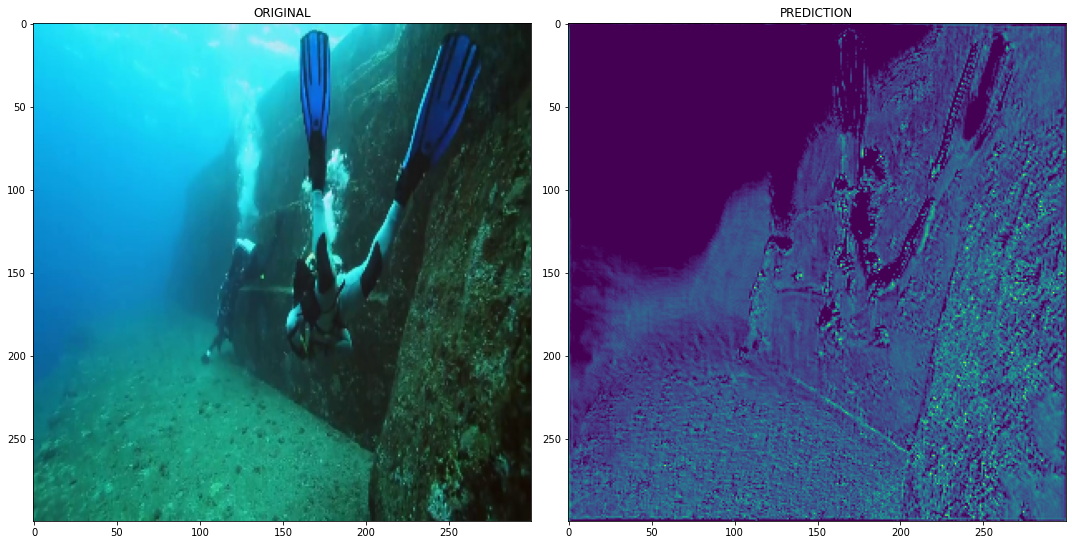

In [18]:
figure,axis = plt.subplots(1,2,figsize=(15,15))

PRE_COUNT = 9

axis[0].imshow(Transformation_Image[PRE_COUNT])
axis[0].set_title("ORIGINAL")
axis[1].imshow(Prediction_Seen[PRE_COUNT])
axis[1].set_title("PREDICTION")

plt.tight_layout()
plt.show()

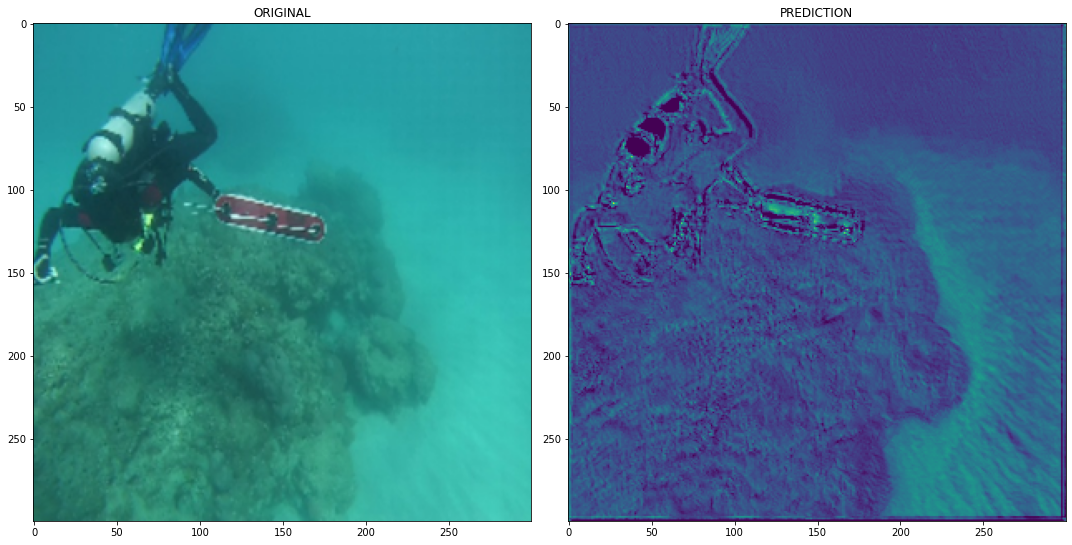

In [9]:
figure,axis = plt.subplots(1,2,figsize=(15,15))

PRE_COUNT = 3

axis[0].imshow(Transformation_Image[PRE_COUNT])
axis[0].set_title("ORIGINAL")
axis[1].imshow(Prediction_Seen[PRE_COUNT])
axis[1].set_title("PREDICTION")

plt.tight_layout()
plt.show()

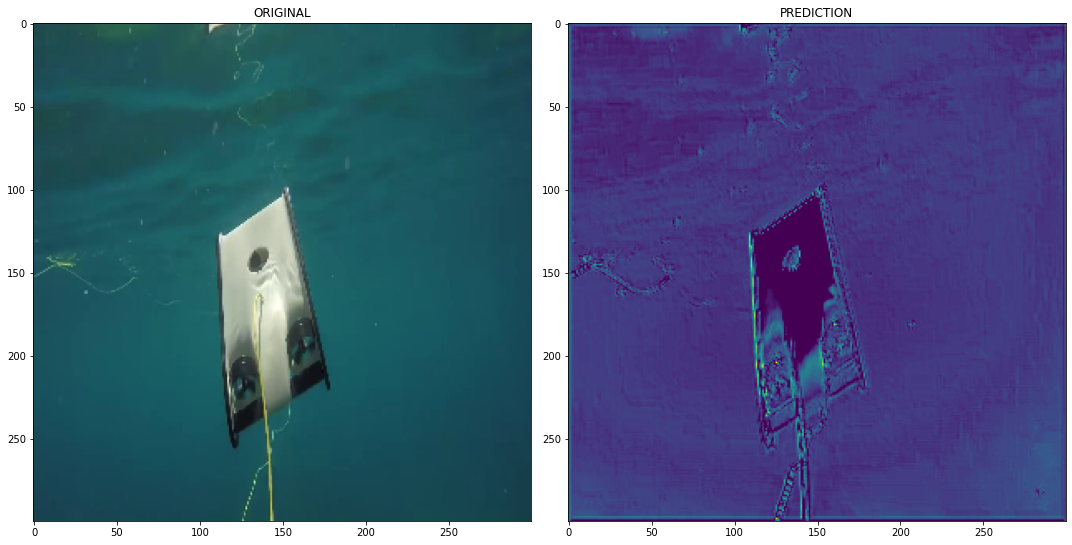

In [13]:
figure,axis = plt.subplots(1,2,figsize=(15,15))

PRE_COUNT = 5

axis[0].imshow(Transformation_Image[PRE_COUNT])
axis[0].set_title("ORIGINAL")
axis[1].imshow(Prediction_Seen[PRE_COUNT])
axis[1].set_title("PREDICTION")

plt.tight_layout()
plt.show()